# rnaseq.novogene_pcks9 - rna_seq
This notebook will create all the necessary files, scripts and folders to pre-process the aforementioned project. Is designed to be used in a jupyter server deployed in a system running SLURM. The majority of the scripts and heavy-lifting processes are wrapped up in sbatch scripts.As an end user, in order to pre-process your samples provided in the spread sheet, you will simply need to *run the entire notebook* (Cell > Run all) and the system should take care of the rest for you.
#### Create necessary folder(s)

In [1]:
%%bash
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/raw_reads
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/processed_raw_reads
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/jsons
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs

Save metadata file

In [2]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata/rna_seq_download_metadata.rnaseq.novogene_pcks9.txt
Sequencing core user	Sequencing core project	Sequencing core password	Sequencing core library name	Name	Paired-end or single-end	Genome	Library type	Strand specificity	With ercc spike-in	Read length
XXXXX	XXXXX	XXXXX	MG1	mm10.rnaseq.PBS.rep1	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG2	mm10.rnaseq.PBS.rep2	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG3	mm10.rnaseq.PCSK9_gRNA.rep1	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG4	mm10.rnaseq.PBS.rep3	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG5	mm10.rnaseq.PCSK9_gRNA.rep2	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG6	mm10.rnaseq.PCSK9_gRNA.rep3	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG7	mm10.rnaseq.PCSK9_gRNA.rep4	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG8	mm10.rnaseq.Control_gRNA.rep1	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG9	mm10.rnaseq.Control_gRNA.rep2	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG10	mm10.rnaseq.Control_gRNA.rep3	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG11	mm10.rnaseq.Control_gRNA.rep4	PE	mm10	RNA-seq	unstranded	False	150
XXXXX	XXXXX	XXXXX	MG12	mm10.rnaseq.PBS.rep4	PE	mm10	RNA-seq	unstranded	False	150


Writing /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata/rna_seq_download_metadata.rnaseq.novogene_pcks9.txt


#### Download FASTQ from sftp
Downloaded from Novogene servers  (see [rnaseq.download_novogene_data.ipynb](rnaseq.download_novogene_data.ipynb))

#### Ungzip FASTQ files

In [3]:
%%bash
ln -s /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/raw_reads/Rawdata /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/raw_reads/rnaseq.novogene_pcks9 

In [9]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/ungzip_rnaseq.novogene_pcks9.sh
#!/bin/bash
ORDER=rnaseq.novogene_pcks9
PROJECT_HOME=/data/reddylab/Alex/collab/20190701_Matt
METADATA=/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata/rna_seq_download_metadata.rnaseq.novogene_pcks9.txt
RAW_DATA_DIR=${PROJECT_HOME}/data/rna_seq/raw_reads/${ORDER}
PROCESSED_DATA_DIR=${PROJECT_HOME}/data/rna_seq/processed_raw_reads/${ORDER}

mkdir -p ${PROCESSED_DATA_DIR}

seq_name_header=$(/bin/grep -Eoi "sequencing.?core.?library.?name" ${METADATA})
if [[ $? == 1 ]];
then
    echo -e "ERROR: Sequencing core library name not found in ${METADATA}"
    exit 1
fi

name_header=$(/bin/grep -Poi "\tname\t" ${METADATA})
if [[ $? == 1 ]];
then
    echo -e "ERROR: Library Name column not found in ${METADATA}"
    exit 1
fi
name_header=$(echo ${name_header} | cut -f2)

seq_type_header=$(head -1 ${METADATA} | /bin/grep -Poi "paired.?end.?or.?single.?end")
if [[ $? == 1 ]];
then
    echo -e "ERROR: Paired-end or single-end column not found in ${METADATA}"
    exit 1
fi

sample_seq_name=$(/data/reddylab/software/bin/print_tab_cols.awk -v cols="${seq_name_header}" ${METADATA} \
    | awk -v SLURM_ARRAY_TASK_ID=${SLURM_ARRAY_TASK_ID} 'NR==SLURM_ARRAY_TASK_ID+1{print}');
sample_name=$(/data/reddylab/software/bin/print_tab_cols.awk -v cols="${name_header}" ${METADATA} \
    | awk -v SLURM_ARRAY_TASK_ID=${SLURM_ARRAY_TASK_ID} 'NR==SLURM_ARRAY_TASK_ID+1{print}');
seq_type=$(/data/reddylab/software/bin/print_tab_cols.awk -v cols="${seq_type_header}" ${METADATA} \
    | awk -v SLURM_ARRAY_TASK_ID=${SLURM_ARRAY_TASK_ID} 'NR==SLURM_ARRAY_TASK_ID+1{print}');

if [[ ! -e ${RAW_DATA_DIR} ]];
then
    RAW_DATA_DIR=${PROJECT_HOME}/data/rna_seq/raw_reads/${ORDER^^}
fi
PROCESSED_DATA_DIR=${PROJECT_HOME}/data/rna_seq/processed_raw_reads/${ORDER}

mkdir -p ${PROCESSED_DATA_DIR}

sample=$(/data/reddylab/software/bin/print_tab_cols.awk -v cols="${seq_name_header}" ${METADATA} |\
            awk -v SLURM_ARRAY_TASK_ID=${SLURM_ARRAY_TASK_ID} 'NR==SLURM_ARRAY_TASK_ID+1{print}');

for read_pair in R1 R2;
do
    if [[ ! -e ${PROCESSED_DATA_DIR}/${sample_name/ /}.${read_pair}.fastq ]];
    then
        gzip -cd ${RAW_DATA_DIR}/${sample/ /}/${sample/ /}_CRRA190013$(printf "%03d" $((121+${SLURM_ARRAY_TASK_ID})))-1a_HNLL3DSXX_L1_${read_pair/R/}.fq.gz \
            > ${PROCESSED_DATA_DIR}/${sample_name/ /}.${read_pair}.fastq;
    fi
done


Overwriting /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/ungzip_rnaseq.novogene_pcks9.sh


Execute file to ungzip FASTQ files

In [10]:
%%script --out blocking_job_str bash -s "$blocking_job"
sbatch -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq.novogene_pcks9_ungzip_fastq_files_%a.out \
 -p new,all \
 --array 11%20 \
 /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/ungzip_rnaseq.novogene_pcks9.sh

Extract blocking job id

In [11]:
import re
blocking_job = re.match('Submitted batch job (\d+).*', blocking_job_str).group(1)

#### Create JSON files for CWL pipeline files

In [12]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/cwl_json_gen_rnaseq.novogene_pcks9.sh
#!/bin/bash
ORDER=rnaseq.novogene_pcks9
PROCESSED_DATA_DIR=/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/processed_raw_reads/${ORDER}
METADATA=/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata/rna_seq_download_metadata.rnaseq.novogene_pcks9.txt

python /data/reddylab/software/cwl/GGR-cwl/v1.0/json-generator/run.py \
    -m ${METADATA} \
    -d ${PROCESSED_DATA_DIR} \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/jsons \
    -t rna-seq \
    --mem 48000 \
    --read-length 150 \
    --nthreads 24 \
    --separate-jsons \
    --skip-star-2pass \

Writing /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/cwl_json_gen_rnaseq.novogene_pcks9.sh


Execute file to create JSON files

In [13]:
%%script --out blocking_job_str bash -s "$blocking_job"
source /data/reddylab/software/miniconda2/bin/activate cwl10
sbatch -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq.novogene_pcks9_cwl_json_gen.out \
 -pnew,all \
 --depend afterok:$1 \
 /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/cwl_json_gen_rnaseq.novogene_pcks9.sh

Extract blocking job id

In [14]:
import re
blocking_job = re.match('Submitted batch job (\d+).*', blocking_job_str).group(1)

#### Create SLURM array master bash file for pe-unstranded-with-sjdb samples

In [15]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.sh
#!/bin/bash
#SBATCH --job-name=cwl_rna_seq
#SBATCH --output=/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb-%a.out
#SBATCH --mail-user=aeb84@duke.edu
#SBATCH --mail-type=FAIL,END
#SBATCH --mem=48000
#SBATCH --cpus-per-task=24

export PATH="/data/reddylab/software/bin:$PATH"
export PATH="/data/reddylab/software/cwl/bin:$PATH"
export PATH="/data/reddylab/software/preseq_v2.0:$PATH"
export PATH="/data/reddylab/software/rsem-1.2.21/:$PATH"
export PATH="/data/reddylab/software/STAR-STAR_2.4.1a/bin/Linux_x86_64/:$PATH"
export PATH="/data/reddylab/software/subread-1.4.6-p4-Linux-x86_64/bin/:$PATH"
export PATH="/data/reddylab/software/bamtools-2.2.3/bin/:$PATH"

export PATH="/data/reddylab/software/miniconda2/envs/cwl10/bin:$PATH"

module load bedtools2
module load fastqc
module load samtools
module load bowtie2
module load java

# For Fastqc
export DISPLAY=:0.0

# Make sure temporary files and folders are created in a specific folder
mkdir -p /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/tmpdirs/tmp-rnaseq.novogene_pcks9-pe-unstranded-with-sjdb-${SLURM_ARRAY_TASK_ID}-
export TMPDIR="/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/tmpdirs/tmp-rnaseq.novogene_pcks9-pe-unstranded-with-sjdb-${SLURM_ARRAY_TASK_ID}-"

cwltool --debug \
    --non-strict \
    --preserve-environment PATH \
    --preserve-environment DISPLAY \
    --preserve-environment TMPDIR \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb  \
    --no-container \
    /data/reddylab/software/cwl/GGR-cwl/v1.0/RNA-seq_pipeline/pipeline-pe-unstranded-with-sjdb.cwl \
    /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/jsons/rna_seq_download_metadata.rnaseq.novogene_pcks9-pe-unstranded-with-sjdb-${SLURM_ARRAY_TASK_ID}.json

Writing /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.sh


Execute SLURM array master file

In [16]:
%%script --out blocking_job_str bash -s "$blocking_job"
source /data/reddylab/software/miniconda2/bin/activate cwl10
sbatch -p new,all \
 --depend afterok:$1 \
 --array 0-11%20 \
 /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.sh

Extract blocking job id

In [17]:
import re
blocking_job = re.match('Submitted batch job (\d+).*', blocking_job_str).group(1)

#### Create QC generating script

In [18]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/generate_qc_cell_rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.sh
#!/bin/bash
#SBATCH --job-name=qc
#SBATCH --output=/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/qc_gen.rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.out

source /data/reddylab/software/miniconda2/bin/activate alex
cd /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb

python /data/reddylab/software/cwl/bin/generate_stats_rnaseq_paired_end.py ./ \
    -samples $(/bin/ls -1 *PBC.txt | sed 's@.PBC.txt@@') \
> qc.txt

Writing /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/generate_qc_cell_rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.sh


Generate QCs for rnaseq.novogene_pcks9-pe-unstranded-with-sjdb

In [19]:
%%script --out blocking_job_str bash -s "$blocking_job"
sbatch -p new,all \
 --depend afterok:$1 \
 /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/scripts/generate_qc_cell_rnaseq.novogene_pcks9-pe-unstranded-with-sjdb.sh

Extract blocking job id

In [ ]:
import re
blocking_job = re.match('Submitted batch job (\d+).*', blocking_job_str).group(1)

In [3]:
import pandas as pd
import re
import os
data_dir = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb'
comp_files = [
    [
        "mm10.rnaseq.Control_gRNA.rep1.star2.featurecounts.counts.txt",
        "mm10.rnaseq.Control_gRNA.rep2.star2.featurecounts.counts.txt",
        "mm10.rnaseq.Control_gRNA.rep3.star2.featurecounts.counts.txt",
        "mm10.rnaseq.Control_gRNA.rep4.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PBS.rep1.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PBS.rep2.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PBS.rep3.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PBS.rep4.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PCSK9_gRNA.rep1.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PCSK9_gRNA.rep2.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PCSK9_gRNA.rep3.star2.featurecounts.counts.txt",
        "mm10.rnaseq.PCSK9_gRNA.rep4.star2.featurecounts.counts.txt"
    ]
]

def clean_count_column(s):
    return ".".join(s.split('/')[-1].split('.')[:4])


for comp_i0, files in enumerate(comp_files):
    df = None
    comp_i1 = comp_i0 + 1

    for f in files:
        df_tmp = pd.read_csv(os.path.join(data_dir, f), sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].round().astype(dtype='int')

    df.columns = [c.replace("-", "_") for c in df.columns]
    df.to_csv('/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts/mm10.rnaseq.novogene_pcks9.all.counts.txt',
             sep='\t')

    

In [2]:
!mkdir /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts

In [1]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex_dev
sbatch -pnew,all \
    --array=0-2 \
    --mem 16G \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq_deseq2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
    mm10.rnaseq.PCSK9_gRNA@mm10.rnaseq.Control_gRNA \
    mm10.rnaseq.PBS@mm10.rnaseq.Control_gRNA \
    mm10.rnaseq.PCSK9_gRNA@mm10.rnaseq.PBS \
)
COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"@" -f1)
CONTROL=$(echo $COMPARISON | cut -d"@" -f2)
Rscript /data/reddylab/Alex/reddylab_utils/scripts/de.deseq2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4}) \
    --controls $(echo ${CONTROL}.rep{1,2,3,4}) \
    --lfcShrink apeglm \
    --counts-skip-ncols 3 \
    --no-model-reps \
    --outdir /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/ \
    --counts /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts/mm10.rnaseq.novogene_pcks9.all.counts.txt
EOF

Submitted batch job 15346484


In [20]:
%%writefile /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py
#!/usr/bin/env python2
import pandas as pd
import json
import sys

infile = sys.argv[1]
outfile = sys.argv[2]
gene_details = pd.read_csv('/data/reddylab/Reference_Data/Gencode/vM13/gencode.vM13.gene_id_to_gene_name.txt', 
                              sep='\t',
                             names = ['ensembl_id', 'gene_name', 'gene_type'])
df = pd.read_csv(infile, sep="\t")
gene_id_to_name = dict(zip(gene_details['ensembl_id'], gene_details['gene_name']))
df['GeneName'] = [gene_id_to_name[k] for k in df.index.values]
gene_id_to_type = dict(zip(gene_details['ensembl_id'], gene_details['gene_type']))
df['GeneType'] = [gene_id_to_type[k] for k in df.index.values]
df.to_csv(outfile, sep="\t", index=True)


Overwriting /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py


In [2]:
%%bash
source /data/reddylab/software/miniconda2/bin/activate alex
cd /data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/
for ii in $(/bin/ls -1 mm10.rnaseq.*.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [1]:
%matplotlib inline

====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026773.19,1097.491263,1.437415,0.316825,2.182701e-07,0.000673,Pfkfb3,protein_coding
1,ENSMUSG00000027533.10,114.837136,2.036723,0.449067,2.325938e-07,0.000673,Fabp5,protein_coding
11,ENSMUSG00000044254.6,373.195269,-1.509638,0.388187,3.601656e-06,0.003475,Pcsk9,protein_coding
12,ENSMUSG00000027009.18,136.072623,-1.275400,0.333047,4.746649e-06,0.004228,Itga4,protein_coding


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026773.19,1097.491263,1.566425,0.302220,5.183064,2.182701e-07,0.000673,Pfkfb3,protein_coding
1,ENSMUSG00000027533.10,114.837136,2.216357,0.428596,5.171201,2.325938e-07,0.000673,Fabp5,protein_coding
7,ENSMUSG00000040022.14,187.667656,-1.057287,0.220027,-4.805266,1.545456e-06,0.002237,Rab11fip2,protein_coding
11,ENSMUSG00000044254.6,373.195269,-1.686476,0.364003,-4.633137,3.601656e-06,0.003475,Pcsk9,protein_coding
12,ENSMUSG00000027009.18,136.072623,-1.429043,0.312312,-4.575685,4.746649e-06,0.004228,Itga4,protein_coding


====== mm10.rnaseq.PBS_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
5,ENSMUSG00000031271.14,290.586581,-1.176456,0.29837,0.000003,0.006846,Serpina7,protein_coding
7,ENSMUSG00000044378.12,80.804832,1.111834,0.29520,0.000006,0.008829,Slc15a5,protein_coding


====== mm10.rnaseq.PBS_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
1,ENSMUSG00000076612.7,378.559593,-7.891559,1.550756,-5.088847,3.602474e-07,0.002086,Ighg2c,IG_C_gene
5,ENSMUSG00000031271.14,290.586581,-1.310427,0.280744,-4.667699,3.045914e-06,0.006846,Serpina7,protein_coding
6,ENSMUSG00000076613.3,124.359963,-4.962552,1.082438,-4.584606,4.548434e-06,0.007524,Ighg2b,IG_C_gene
7,ENSMUSG00000044378.12,80.804832,1.248625,0.276067,4.522897,6.099907e-06,0.008829,Slc15a5,protein_coding


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000044254.6,373.195269,-2.382116,0.372390,6.456480e-12,7.475958e-08,Pcsk9,protein_coding
1,ENSMUSG00000034936.2,598.514665,-1.095460,0.187413,2.154591e-10,1.247400e-06,Arl4d,protein_coding
2,ENSMUSG00000076613.3,124.359963,5.069038,1.145972,3.074311e-07,8.899363e-04,Ighg2b,IG_C_gene
5,ENSMUSG00000052117.5,256.721962,1.081330,0.281515,4.556953e-06,8.794159e-03,D630039A03Rik,protein_coding
6,ENSMUSG00000031271.14,290.586581,1.133359,0.300470,6.014555e-06,9.948933e-03,Serpina7,protein_coding


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000044254.6,373.195269,-2.494369,0.363124,-6.869196,6.456480e-12,7.475958e-08,Pcsk9,protein_coding
1,ENSMUSG00000034936.2,598.514665,-1.156393,0.182112,-6.349897,2.154591e-10,1.247400e-06,Arl4d,protein_coding
2,ENSMUSG00000076613.3,124.359963,5.538813,1.082046,5.118834,3.074311e-07,8.899363e-04,Ighg2b,IG_C_gene
5,ENSMUSG00000052117.5,256.721962,1.210340,0.264023,4.584215,4.556953e-06,8.794159e-03,D630039A03Rik,protein_coding
6,ENSMUSG00000031271.14,290.586581,1.272347,0.281127,4.525877,6.014555e-06,9.948933e-03,Serpina7,protein_coding


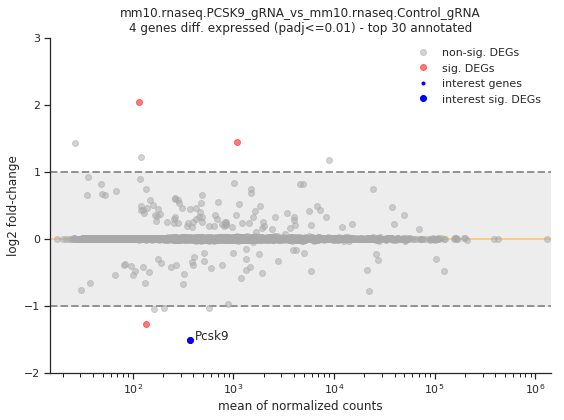

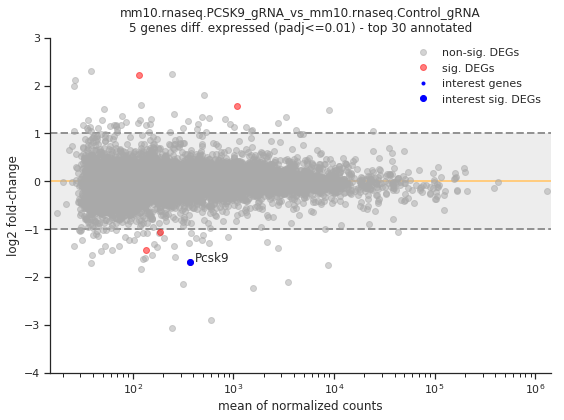

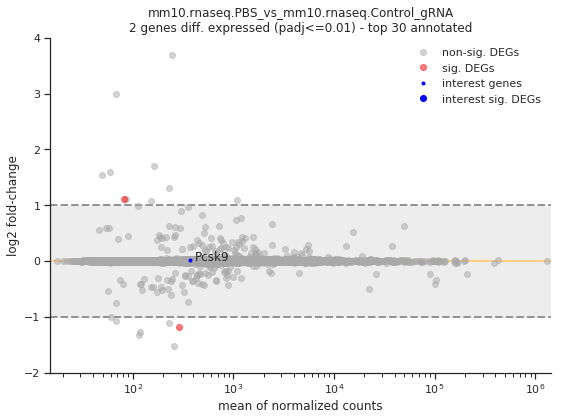

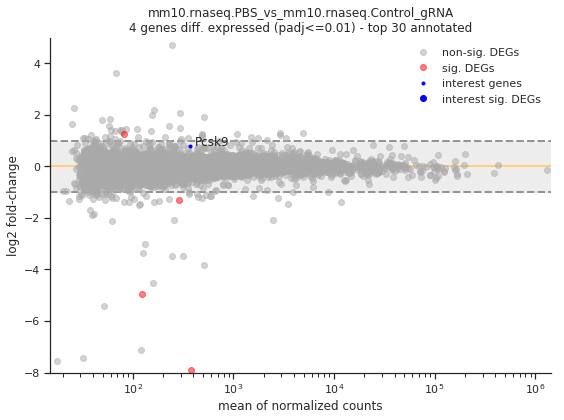

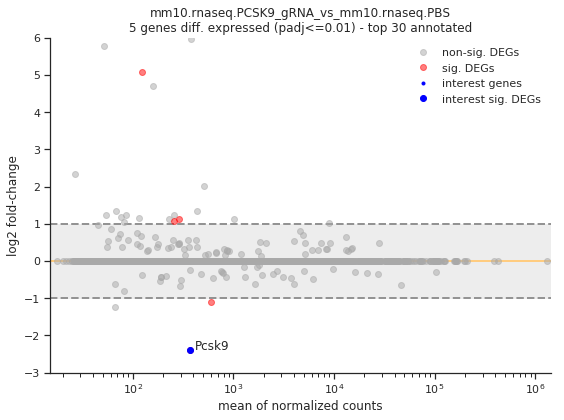

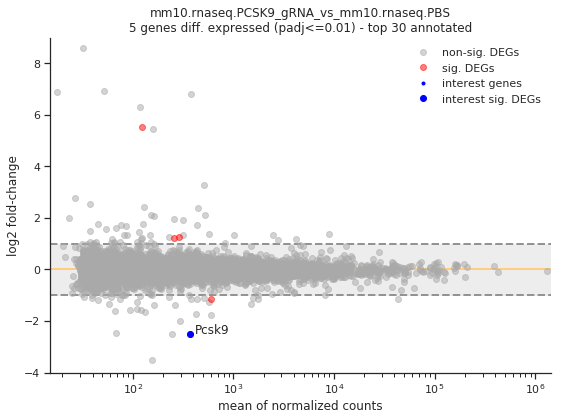

In [27]:
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import patches
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
log2fc_thres = 1
pval_thres = 0.01
top_to_report = 30
special_genes = ["Pcsk9"]
comparisons = [
    "mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.Control_gRNA",
    "mm10.rnaseq.PBS_vs_mm10.rnaseq.Control_gRNA",
    "mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.PBS"
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
        df = df.loc[~df.GeneType.str.contains('pseudogene'), :]
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
        fig = plt.figure(figsize=(8, 6))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey', alpha=0.5, label='non-sig. DEGs')

        ylims = [np.ceil(df['log2FoldChange'].min()-1), 
                 np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]
        df_sig = df[(df.padj<=pval_thres) & (np.abs(df.log2FoldChange)>=log2fc_thres)]
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', 
                alpha=0.5, label='sig. DEGs')

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes')
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')

        plt.xlim(xlims)
        plt.ylim(ylims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")
        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres) & (np.abs(df.log2FoldChange)>=log2fc_thres)), 
                                                                                    pval_thres, 
                                                                                    top_to_report))
        ax.add_patch(patches.Rectangle((0, -log2fc_thres), xlims[1], 2*log2fc_thres, fill=True, color='#ededed'))
        plt.hlines(0, xlims[0], xlims[1], color='#ffcc80', linewidth =2 )
        plt.hlines(-log2fc_thres, xlims[0], xlims[1], color='#939393', linewidth =2, linestyle= '--' )
        plt.hlines(log2fc_thres, xlims[0], xlims[1], color='#939393', linewidth =2, linestyle= '--' )
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
        plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)
    
   


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026773.19,1097.491263,1.437415,0.316825,2.182701e-07,0.000673,Pfkfb3,protein_coding
1,ENSMUSG00000027533.10,114.837136,2.036723,0.449067,2.325938e-07,0.000673,Fabp5,protein_coding
2,ENSMUSG00000064254.6,713.165503,0.835814,0.182703,1.976404e-07,0.000673,Ethe1,protein_coding
3,ENSMUSG00000053617.11,733.515840,0.580608,0.124453,1.249730e-07,0.000673,Sh3pxd2a,protein_coding
4,ENSMUSG00000029727.7,6550.802394,-0.738507,0.165254,3.958781e-07,0.000917,Cyp3a13,protein_coding
5,ENSMUSG00000021474.8,2470.324846,-0.402156,0.095041,9.539892e-07,0.001841,Sfxn1,protein_coding
6,ENSMUSG00000015224.10,469.350280,-0.549305,0.133456,1.524707e-06,0.002237,Cyp2j9,protein_coding
7,ENSMUSG00000040022.14,187.667656,-0.955841,0.232572,1.545456e-06,0.002237,Rab11fip2,protein_coding
8,ENSMUSG00000078964.2,3093.725258,-0.601817,0.146975,1.861306e-06,0.002395,Ces1b,protein_coding
9,ENSMUSG00000079012.11,9893.003322,-0.485835,0.120190,2.126848e-06,0.002463,Serpina3m,protein_coding


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026773.19,1097.491263,1.566425,0.302220,5.183064,2.182701e-07,0.000673,Pfkfb3,protein_coding
1,ENSMUSG00000027533.10,114.837136,2.216357,0.428596,5.171201,2.325938e-07,0.000673,Fabp5,protein_coding
2,ENSMUSG00000064254.6,713.165503,0.908235,0.174609,5.201543,1.976404e-07,0.000673,Ethe1,protein_coding
3,ENSMUSG00000053617.11,733.515840,0.629896,0.119161,5.286069,1.249730e-07,0.000673,Sh3pxd2a,protein_coding
4,ENSMUSG00000029727.7,6550.802394,-0.799510,0.157665,-5.070929,3.958781e-07,0.000917,Cyp3a13,protein_coding
5,ENSMUSG00000021474.8,2470.324846,-0.442450,0.090279,-4.900899,9.539892e-07,0.001841,Sfxn1,protein_coding
6,ENSMUSG00000015224.10,469.350280,-0.607381,0.126328,-4.807970,1.524707e-06,0.002237,Cyp2j9,protein_coding
7,ENSMUSG00000040022.14,187.667656,-1.057287,0.220027,-4.805266,1.545456e-06,0.002237,Rab11fip2,protein_coding
8,ENSMUSG00000078964.2,3093.725258,-0.662791,0.139010,-4.767928,1.861306e-06,0.002395,Ces1b,protein_coding
9,ENSMUSG00000079012.11,9893.003322,-0.538366,0.113556,-4.740982,2.126848e-06,0.002463,Serpina3m,protein_coding


====== mm10.rnaseq.PBS_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026107.11,371.760919,0.789996,0.168926,1.223190e-07,0.001416,Nabp1,protein_coding
1,ENSMUSG00000076612.7,378.559593,-0.001926,0.039004,3.602474e-07,0.002086,Ighg2c,IG_C_gene
2,ENSMUSG00000073609.9,477.035038,0.739086,0.179730,1.590529e-06,0.004604,D2hgdh,protein_coding
3,ENSMUSG00000035234.18,141.823307,-0.685850,0.166237,1.477904e-06,0.004604,Fam175a,protein_coding
4,ENSMUSG00000030795.18,1899.267854,-0.389107,0.097591,3.547219e-06,0.006846,Fus,protein_coding
5,ENSMUSG00000031271.14,290.586581,-1.176456,0.298370,3.045914e-06,0.006846,Serpina7,protein_coding
6,ENSMUSG00000076613.3,124.359963,-0.003813,0.039210,4.548434e-06,0.007524,Ighg2b,IG_C_gene
7,ENSMUSG00000044378.12,80.804832,1.111834,0.295200,6.099907e-06,0.008829,Slc15a5,protein_coding


====== mm10.rnaseq.PBS_vs_mm10.rnaseq.Control_gRNA ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000026107.11,371.760919,0.855362,0.161694,5.289996,1.223190e-07,0.001416,Nabp1,protein_coding
1,ENSMUSG00000076612.7,378.559593,-7.891559,1.550756,-5.088847,3.602474e-07,0.002086,Ighg2c,IG_C_gene
2,ENSMUSG00000073609.9,477.035038,0.816678,0.170159,4.799512,1.590529e-06,0.004604,D2hgdh,protein_coding
3,ENSMUSG00000035234.18,141.823307,-0.758006,0.157452,-4.814200,1.477904e-06,0.004604,Fam175a,protein_coding
4,ENSMUSG00000030795.18,1899.267854,-0.428035,0.092323,-4.636288,3.547219e-06,0.006846,Fus,protein_coding
5,ENSMUSG00000031271.14,290.586581,-1.310427,0.280744,-4.667699,3.045914e-06,0.006846,Serpina7,protein_coding
6,ENSMUSG00000076613.3,124.359963,-4.962552,1.082438,-4.584606,4.548434e-06,0.007524,Ighg2b,IG_C_gene
7,ENSMUSG00000044378.12,80.804832,1.248625,0.276067,4.522897,6.099907e-06,0.008829,Slc15a5,protein_coding


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000044254.6,373.195269,-2.382116,0.372390,6.456480e-12,7.475958e-08,Pcsk9,protein_coding
1,ENSMUSG00000034936.2,598.514665,-1.095460,0.187413,2.154591e-10,1.247400e-06,Arl4d,protein_coding
2,ENSMUSG00000076613.3,124.359963,5.069038,1.145972,3.074311e-07,8.899363e-04,Ighg2b,IG_C_gene
3,ENSMUSG00000022181.15,5660.845463,0.560861,0.125208,3.066909e-07,8.899363e-04,C6,protein_coding
5,ENSMUSG00000052117.5,256.721962,1.081330,0.281515,4.556953e-06,8.794159e-03,D630039A03Rik,protein_coding
6,ENSMUSG00000031271.14,290.586581,1.133359,0.300470,6.014555e-06,9.948933e-03,Serpina7,protein_coding


====== mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.PBS ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000044254.6,373.195269,-2.494369,0.363124,-6.869196,6.456480e-12,7.475958e-08,Pcsk9,protein_coding
1,ENSMUSG00000034936.2,598.514665,-1.156393,0.182112,-6.349897,2.154591e-10,1.247400e-06,Arl4d,protein_coding
2,ENSMUSG00000076613.3,124.359963,5.538813,1.082046,5.118834,3.074311e-07,8.899363e-04,Ighg2b,IG_C_gene
3,ENSMUSG00000022181.15,5660.845463,0.611210,0.119394,5.119288,3.066909e-07,8.899363e-04,C6,protein_coding
5,ENSMUSG00000052117.5,256.721962,1.210340,0.264023,4.584215,4.556953e-06,8.794159e-03,D630039A03Rik,protein_coding
6,ENSMUSG00000031271.14,290.586581,1.272347,0.281127,4.525877,6.014555e-06,9.948933e-03,Serpina7,protein_coding


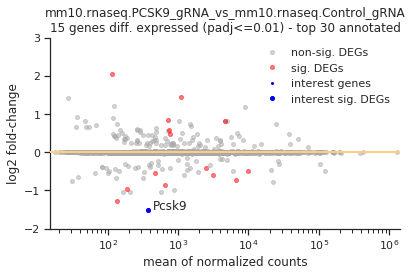

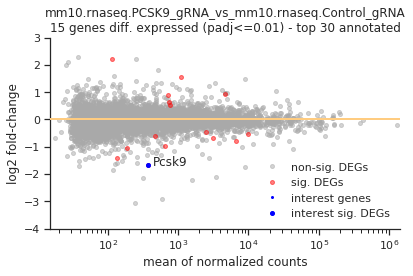

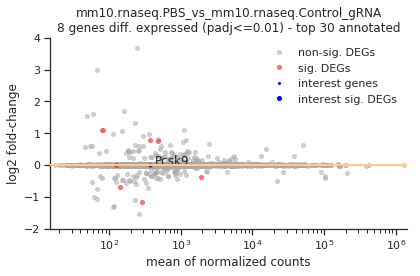

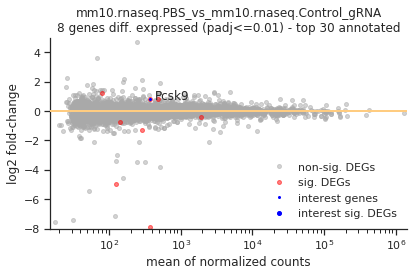

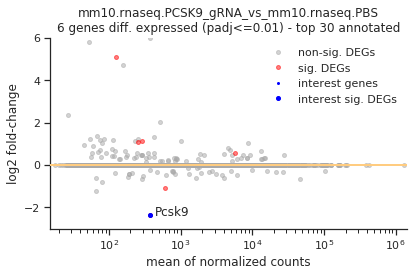

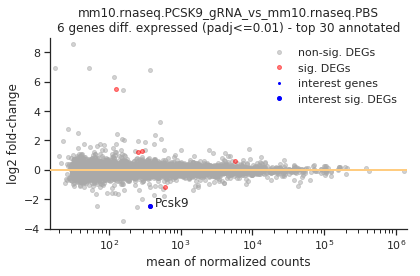

In [2]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
log2fc_thres = 1
pval_thres = 0.01
top_to_report = 30
special_genes = ["Pcsk9"]
comparisons = [
    "mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.Control_gRNA",
    "mm10.rnaseq.PBS_vs_mm10.rnaseq.Control_gRNA",
    "mm10.rnaseq.PCSK9_gRNA_vs_mm10.rnaseq.PBS"
]

data_dir = '/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing'

for comparison in comparisons:
    for shrinkage in ['', '.unshrunk']:
        df = pd.read_csv("%s/%s%s.with_genes.txt" % (data_dir, comparison, shrinkage),
                        sep="\t")
        df = df.loc[~df.GeneType.str.contains('pseudogene'), :]
    #     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
    #                     sep="\t",
    #                     names=['GeneName', 'GeneType'])
    #     df = df.merge(df_gene_name_type, on='GeneName')
    #     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
    #     df = df[~df.GeneType.isin(pseudogene_types)]
    #     df = df[df.GeneType.isin(['protein_coding'])]
#         fig = plt.figure(figsize=(8, 6))
        fig = plt.figure(figsize=(6, 4))
        ax = plt.subplot(1, 1, 1)
        df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
        ax.set_xscale('log')
        ax.plot(df_non_sig['baseMean'].values, 
                df_non_sig['log2FoldChange'].values, 
                'o', color='darkgrey', alpha=0.5, label='non-sig. DEGs', rasterized=True, markersize=4)

        ylims = [np.ceil(df['log2FoldChange'].min()-1), 
                 np.floor(df['log2FoldChange'].max()+1)]
        xlims = [np.floor(df.baseMean.min()*1.1), np.ceil(df.baseMean.max()*1.1)]
        df_sig = df[(df.padj<=pval_thres)] #& (np.abs(df.log2FoldChange)>=log2fc_thres)
        ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', 
                alpha=0.5, label='sig. DEGs', markersize=4)

        # Annotate the top top_to_report
        df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    #     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
    #         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
    #     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

    #     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
    #         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
    #                     textcoords='offset points')

        # Annotate in particular IL1RN, HBG and EP300
        df_annotate_selected = df[df.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='.', linestyle = 'None', alpha=1, label='interest genes', markersize=4)
        for x, y, t in zip(df_annotate_selected['baseMean'].values,
                           df_annotate_selected['log2FoldChange'].values, 
                           df_annotate_selected['GeneName'].values) :
            ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                    textcoords='offset points')
        df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
        ax.plot(df_annotate_selected['baseMean'].values, 
                df_annotate_selected['log2FoldChange'].values,color='blue', 
                marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs', markersize=4)

        plt.xlim(xlims)
        plt.ylim(ylims)
        plt.xlabel("mean of normalized counts")
        plt.ylabel("log2 fold-change")

        plt.title("%s\n%d genes diff. expressed (padj<=%.2f) - top %d annotated" % (comparison, 
                                                                                    np.count_nonzero((df.padj<=pval_thres)), #  & (np.abs(df.log2FoldChange)>=log2fc_thres)
                                                                                    pval_thres, 
                                                                                    top_to_report))
        plt.hlines(0, xlims[0], xlims[1], color='#ffcc80', linewidth =2, zorder=100)
        plt.legend(frameon=False)

        # Remove spines and tight the layout
        simpleaxis(ax)
        plt.tight_layout()

    #     # Save annotated MA plot
#         plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.log2fc_gt_1.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))
        plt.savefig("/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/differntial_testing/degs.%s%s.with_genes.annotated_plot_MA.pdf" % (comparison, shrinkage))

    #     # Save annotated genes without pseudogenes
    #     df_annotate.to_csv("/data/reddylab/Alex/collab/20180214_JoshBlack/results/rna_seq/degs%s.with_genes.sig_DE_no_pseudogenes.txt" % comparison,
    #                       sep='\t',
    #                       index=False)

        # print table of values 
        print "======", comparison, "======"
        display(df_annotate)
    
   


In [1]:
%%writefile /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.fa
>dCas9-KRAB
atggactgttcgaatggacgaATGGACTACAAAGACCATGACGGTGATTATAAAGATCATGACATCGATTACAAGGATGACGATGACAAGatggcccccaagaagaagaggaaggtgggccgcggaATGGACAAGAAGTACTCCATTGGGCTCGCCATCGGCACAAACAGCGTCGGCTGGGCCGTCATTACGGACGAGTACAAGGTGCCGAGCAAAAAATTCAAAGTTCTGGGCAATACCGATCGCCACAGCATAAAGAAGAACCTCATTGGCGCCCTCCTGTTCGACTCCGGGGAAACCGCCGAAGCCACGCGGCTCAAAAGAACAGCACGGCGCAGATATACCCGCAGAAAGAATCGGATCTGCTACCtgcaGGAGATCTTTAGTAATGAGATGGCTAAGGTGGATGACTCTTTCTTCCATAGGCTGGAGGAGTCCTTTTTGGTGGAGGAGGATAAAAAGCACGAGCGCCACCCAATCTTTGGCAATATCGTGGACGAGGTGGCGTACCATGAAAAGTACCCAACCATATATCATCTGAGGAAGAAGCTTGTAGACAGTACTGATAAGGCTGACTTGCGGTTGATCTATCTCGCGCTGGCGCATATGATCAAATTTCGGGGACACTTCCTCATCGAGGGGGACCTGAACCCAGACAACAGCGATGTCGACAAACTCTTTATCCAACTGGTTCAGACTTACAATCAGCTTTTCGAAGAGAACCCGATCAACGCATCCGGAGTTGACGCCAAAGCAATCCTGAGCGCTAGGCTGTCCAAATCCCGGCGGCTCGAAAACCTCATCGCACAGCTCCCTGGGGAGAAGAAGAACGGCCTGTTTGGTAATCTTATCGCCCTGTCACTCGGGCTGACCCCCAACTTTAAATCTAACTTCGACCTGGCCGAAGATGCCAAGCTTCAACTGAGCAAAGACACCTACGATGATGATCTCGACAATCTGCTGGCCCAGATCGGCGACCAGTACGCAGACCTTTTTTTGGCGGCAAAGAACCTGTCAGACGCCATTCTGCTGAGTGATATTCTGCGAGTGAACACGGAGATCACCAAAGCTCCGCTGAGCGCTAGTATGATCAAGCGCTATGATGAGCACCACCAAGACTTGACTTTGCTGAAGGCCCTTGTCAGACAGCAACTGCCTGAGAAGTACAAGGAAATTTTCTTCGATCAGTCTAAAAATGGCTACGCCGGATACATTGACGGCGGAGCAAGCCAGGAGGAATTTTACAAATTTATTAAGCCCATCTTGGAAAAAATGGACGGCACCGAGGAGCTGCTGGTAAAGCTTAACAGAGAAGATCTGTTGCGCAAACAGCGCACTTTCGACAATGGAAGCATCCCCCACCAGATTCACCTGGGCGAACTGCACGCTATCCTCAGGCGGCAAGAGGATTTCTACCCCTTTTTGAAAGATAACAGGGAAAAGATTGAGAAAATCCTCACATTTCGGATACCCTACTATGTAGGCCCCCTCGCCCGGGGAAATTCCAGATTCGCGTGGATGACTCGCAAATCAGAAGAGACCATCACTCCCTGGAACTTCGAGGAAGTCGTGGATAAGGGGGCCTCTGCCCAGTCCTTCATCGAAAGGATGACTAACTTTGATAAAAATCTGCCTAACGAAAAGGTGCTTCCTAAACACTCTCTGCTGTACGAGTACTTCACAGTTTATAACGAGCTCACCAAGGTCAAATACGTCACAGAAGGGATGAGAAAGCCAGCATTCCTGTCTGGAGAGCAGAAGAAAGCTATCGTGGACCTCCTCTTCAAGACGAACCGGAAAGTTACCGTGAAACAGCTCAAAGAAGACTATTTCAAAAAGATTGAATGTTTCGACTCTGTTGAAATCAGCGGAGTGGAGGATCGCTTCAACGCATCCCTGGGAACGTATCACGATCTCCTGAAAATCATTAAAGACAAGGACTTCCTGGACAATGAGGAGAACGAGGACATTCTTGAGGACATTGTCCTCACCCTTACGTTGTTTGAAGATAGGGAGATGATTGAAGAACGCTTGAAAACTTACGCTCATCTCTTCGACGACAAAGTCATGAAACAGCTCAAGAGGCGCCGATATACAGGATGGGGGCGGCTGTCAAGAAAACTGATCAATGGgatcCGAGACAAGCAGAGTGGAAAGACAATCCTGGATTTTCTTAAGTCCGATGGATTTGCCAACCGGAACTTCATGCAGTTGATCCATGATGACTCTCTCACCTTTAAGGAGGACATCCAGAAAGCACAAGTTTCTGGCCAGGGGGACAGTCTTCACGAGCACATCGCTAATCTTGCAGGTAGCCCAGCTATCAAAAAGGGAATACTGCAGACCGTTAAGGTCGTGGATGAACTCGTCAAAGTAATGGGAAGGCATAAGCCCGAGAATATCGTTATCGAGATGGCCCGAGAGAACCAAACTACCCAGAAGGGACAGAAGAACAGTAGGGAAAGGATGAAGAGGATTGAAGAGGGTATAAAAGAACTGGGGTCCCAAATCCTTAAGGAACACCCAGTTGAAAACACCCAGCTTCAGAATGAGAAGCTCTACCTGTACTACCTGCAGAACGGCAGGGACATGTACGTGGATCAGGAACTGGACATCAATCGGCTCTCCGACTACGACGTGGATGCCATCGTGCCCCAGTCTTTTCTCAAAGATGATTCTATTGATAATAAAGTGTTGACAAGATCCGATAAAAATAGAGGGAAGAGTGATAACGTCCCCTCAGAAGAAGTTGTCAAGAAAATGAAAAATTATTGGCGGCAGCTGCTGAACGCCAAACTGATCACACAACGGAAGTTCGATAATCTGACTAAGGCTGAACGAGGTGGCCTGTCTGAGTTGGATAAAGCCGGCTTCATCAAAAGGCAGCTTGTTGAGACACGCCAGATCACCAAgcacGTGGCCCAAATTCTCGATTCACGCATGAACACCAAGTACGATGAAAATGACAAACTGATTCGAGAGGTGAAAGTTATTACTCTGAAGTCTAAGCTGGTCTCAGATTTCAGAAAGGACTTTCAGTTTTATAAGGTGAGAGAGATCAACAATTACCACCATGCGCATGATGCCTACCTGAATGCAGTGGTAGGCACTGCACTTATCAAAAAATATCCCAAGCTTGAATCTGAATTTGTTTACGGAGACTATAAAGTGTACGATGTTAGGAAAATGATCGCAAAGTCTGAGCAGGAAATAGGCAAGGCCACCGCTAAGTACTTCTTTTACAGCAATATTATGAATTTTTTCAAGACCGAGATTACACTGGCCAATGGAGAGATTCGGAAGCGACCACTTATCGAAACAAACGGAGAAACAGGAGAAATCGTGTGGGACAAGGGTAGGGATTTCGCGACAGTCCGGAAGGTCCTGTCCATGCCGCAGGTGAACATCGTTAAAAAGACCGAAGTACAGACCGGAGGCTTCTCCAAGGAAAGTATCCTCCCGAAAAGGAACAGCGACAAGCTGATCGCACGCAAAAAAGATTGGGACCCCAAGAAATACGGCGGATTCGATTCTCCTACAGTCGCTTACAGTGTACTGGTTGTGGCCAAAGTGGAGAAAGGGAAGTCTAAAAAACTCAAAAGCGTCAAGGAACTGCTGGGCATCACAATCATGGAGCGATCAAGCTTCGAAAAAAACCCCATCGACTTTCTCGAGGCGAAAGGATATAAAGAGGTCAAAAAAGACCTCATCATTAAGCTTCCCAAGTACTCTCTCTTTGAGCTTGAAAACGGCCGGAAACGAATGCTCGCTAGTGCGGGCGAGCTGCAGAAAGGTAACGAGCTGGCACTGCCCTCTAAATACGTTAATTTCTTGTATCTGGCCAGCCACTATGAAAAGCTCAAAGGGTCTCCCGAAGATAATGAGCAGAAGCAGCTGTTCGTGGAACAACACAAACACTACCTTGATGAGATCATCGAGCAAATAAGCGAATTCTCCAAAAGAGTGATCCTCGCCGACGCTAACCTCGATAAGGTGCTTTCTGCTTACAATAAGCACAGGGATAAGCCCATCAGGGAGCAGGCAGAAAACATTATCCACTTGTTTACTCTGACCAACTTGGGCGCGCCTGCAGCCTTCAAGTACTTCGACACCACCATAGACAGAAAGCGGTACACCTCTACAAAGGAGGTCCTGGACGCCACACTGATTCATCAGTCAATTACGGGGCTCTATGAAACAAGAATCGACCTCTCTCAGCTCGGTGGAGACAGCAGGGCTGACCCCAAGAAGAAGAGGAAGGTGGctagCGATGCTAAGTCACTGACTGCCTGGTCCCGGACACTGGTGACCTTCAAGGATGTGTTTGTGGACTTCACCAGGGAGGAGTGGAAGCTGCTGGACACTGCTCAGCAGATCCTGTACAGAAATGTGATGCTGGAGAACTATAAGAACCTGGTTTCCTTGGGTTATCAGCTTACTAAGCCAGATGTGATCCTCCGGTTGGAGAAGGGAGAAGAGCCCTGGCTGGTGGAGAGAGAAATTCACCAAGAGACCCATCCTGATTCAGAGACTGCATTTGAAATCAAATCATCAGTTCCGAAAAAGAAACGCAAAGttTAA

Writing /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.fa


In [2]:
%%bash
module load bowtie2
bowtie2-build \
    /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.fa \
    /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.bt2_index

Settings:
  Output files: "/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.bt2_index.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1145
Using parameters --bmax 859 --dcv 1024
  Doing ahead-of-time memory usa

Building a SMALL index


#### Align against dCas9-KRAB

In [2]:
%%bash
module load bowtie2
module load samtools
SAMPLES=($(/data/reddylab/software/bin/print_tab_cols.awk  -vcols="Name"  /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata/rna_seq_download_metadata.rnaseq.novogene_pcks9.txt))
sbatch --partition new,all \
    --array 0-$((${#SAMPLES[@]}-1)) \
    --mem 8G \
    --cpus-per-task 8 \
    -o /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq.bt2_map.dCas9_KRAB.%a.out \
    <<'EOF'
#!/bin/bash
SAMPLES=($(/data/reddylab/software/bin/print_tab_cols.awk  -vcols="Name"  /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/metadata/rna_seq_download_metadata.rnaseq.novogene_pcks9.txt))
SAMPLE=${SAMPLES[${SLURM_ARRAY_TASK_ID}]}
bowtie2 \
    --threads 8 \
    -X 2000 \
    --no-discordant \
    --sensitive-local \
    -x /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/reference/dcas9_krab.bt2_index \
    -1 /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/processed_raw_reads/rnaseq.novogene_pcks9/${SAMPLE}.R1.fastq \
    -2 /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/processed_raw_reads/rnaseq.novogene_pcks9/${SAMPLE}.R2.fastq \
| samtools view -b - \
> /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb/${SAMPLE}.dCas9_KRAB.sorted.bam \
&& echo "Done ${SAMPLE}!" \
|| echo "Failed ${SAMPLE}"

EOF

Submitted batch job 14812017


In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("notebook")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


In [2]:
reads = !/bin/grep -h -P "(aligned exactly|Done)" /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq.bt2_map.dCas9_KRAB.*.fixed.out  | awk 'NR%2==1{printf $1"\t"}'
reads = [int(c) for c in reads[0].split()]

In [3]:
samples = !/bin/grep -h -P "(aligned exactly|Done)" /data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/logs/rnaseq.bt2_map.dCas9_KRAB.*.fixed.out | awk 'NR%2==0{print $2}'
samples =  [c.strip('!') for c in samples]

In [4]:
conditions = [c.split('.')[2] for c in samples]

In [5]:
mapped_reads = '/data/reddylab/Alex/collab/20190701_Matt/processing/rna_seq/rnaseq.novogene_pcks9-pe-unstranded-with-sjdb/%s.R1.trimmed.fastq.transcriptome.star2.Log.final.out.read_count.mapped'

lib_sizes = [int(np.loadtxt(mapped_reads % c)[1]) for c in samples]
df = pd.DataFrame(index=samples, 
                  data={'cpms':  1e6*(np.array(reads))/np.array(lib_sizes), 
                        'condition':  conditions})
# df = df.astype(int, errors='ignore')

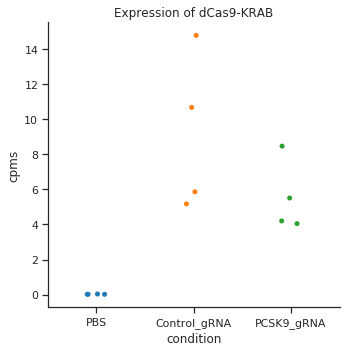

In [6]:
g = sns.catplot(y='cpms', x='condition', data=df, order=['PBS', 'Control_gRNA', 'PCSK9_gRNA'])
plt.title('Expression of dCas9-KRAB')
sns.despine()
plt.tight_layout()
g.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/dCas9_KRAB.cpms.pdf')

In [7]:
df.to_csv('/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts/dCas9_KRAB.cpms.txt', sep='\t')

For PCSK9

In [8]:
reads = !grep -i ENSMUSG00000044254.6 /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts/mm10.rnaseq.novogene_pcks9.all.counts.txt  | cut -f5- 
reads = [int(c) for c in reads[0].split()]

In [9]:
samples = !head -n1 /data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts/mm10.rnaseq.novogene_pcks9.all.counts.txt  | cut -f5- 
samples = [c for c in samples[0].split()]

In [10]:
conditions = [c.split('.')[2] for c in samples]

In [11]:
df_pcsk9 = pd.DataFrame(index=samples, 
                  data={'cpms':  1e6*(np.array(reads))/np.array(lib_sizes), 
                        'condition':  conditions})

In [12]:
df_pcsk9.to_csv('/data/reddylab/Alex/collab/20190701_Matt/data/rna_seq/counts/dCas9_PCSK9.cpms.txt', sep='\t')

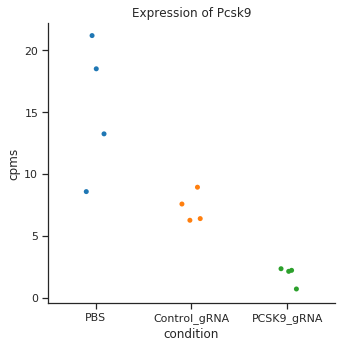

In [37]:
g = sns.catplot(y='cpms', x='condition', data=df_pcsk9, order=['PBS', 'Control_gRNA', 'PCSK9_gRNA'])
plt.title('Expression of Pcsk9')
sns.despine()
plt.tight_layout()
g.savefig('/data/reddylab/Alex/collab/20190701_Matt/results/rna_seq/counts/dCas9_PCKS9.cpms.pdf')

In [39]:
from scipy.stats import ttest_ind, f_oneway
def get_stats(a, b, method = 'anova'):
    if method == 'anova':
        return f_oneway(a, b)
    elif method == 'ttest_ind':
        return ttest_ind(a, b)
    else:
        return "%s not implemented" % method


In [45]:
targeted_values = df_pcsk9.loc[df_pcsk9['condition']=='PCSK9_gRNA', 'cpms'].values
scram_values = df_pcsk9.loc[df_pcsk9['condition']=='Control_gRNA', 'cpms'].values
pbs_values = df_pcsk9.loc[df_pcsk9['condition']=='PBS', 'cpms'].values
print "--- ANOVA ---"
print "targeted vs scram\t", get_stats(targeted_values, scram_values, method = 'anova')
print "targeted vs pbs\t",get_stats(targeted_values, pbs_values, method = 'anova')
print "scram vs pbs\t",get_stats(scram_values, pbs_values, method = 'anova')
print "--- t-test ---"
print "targeted vs scram\t", get_stats(targeted_values, scram_values, method = 'ttest_ind')
print "targeted vs pbs\t",get_stats(targeted_values, pbs_values, method = 'ttest_ind')
print "scram vs pbs\t",get_stats(scram_values, pbs_values, method = 'ttest_ind')


--- ANOVA ---
targeted vs scram	F_onewayResult(statistic=55.49944728446841, pvalue=0.0003014790635753075)
targeted vs pbs	F_onewayResult(statistic=22.859470374054254, pvalue=0.003059203842311582)
scram vs pbs	F_onewayResult(statistic=7.931390504546677, pvalue=0.030503348315380756)
--- t-test ---
targeted vs scram	Ttest_indResult(statistic=-7.449795116945733, pvalue=0.0003014790635753064)
targeted vs pbs	Ttest_indResult(statistic=-4.781157848686262, pvalue=0.0030592038423115837)
scram vs pbs	Ttest_indResult(statistic=-2.8162724485650665, pvalue=0.030503348315380763)
